In [1]:
import collections
import itertools
import json
import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

100%|██████████████████████████████| 1496348/1496348 [01:03<00:00, 23507.20it/s]


STATS:
	novelty_post_count: 116537
	total_post_count: 1496348
	non_novel_post_count: 1379811


116537it [00:05, 19848.56it/s]


NameError: name 'val_annual_rank_distros' is not defined

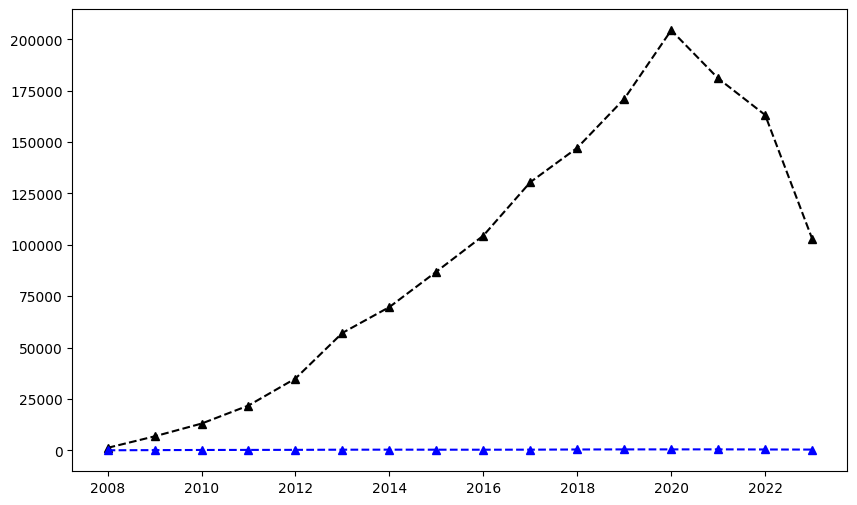

In [14]:
plt.figure(figsize=(10,6))

language="python"
with open(f"data/results/{language}/{language}_{language}_daily_post_stats.json") as handle:
    daily_post_count = json.load(handle)

with open(f"data/results/{language}/{language}_{language}_post_stats.json") as handle:
    post_stats = json.load(handle)
sorted_post_stats = sorted(post_stats, key=lambda item:  datetime.datetime.strptime(item['date'], "%Y-%m-%dT%H:%M:%S.%f"))

with open(f"data/results/{language}/{language}_pairs_first_dates.json") as handle:
    pairs_first_dates = json.load(handle)

with open(f"data/results/{language}/{language}_all_pairs_dates.json") as handle:
    pairs_dates = json.load(handle)

with open(f"data/results/{language}/{language}_user_to_posts.json") as handle:
    user_to_posts = json.load(handle)



VALUE_THRESHOLDS = [2, 5]#[25, 50, 100, 200]
VALUE_TIME_WINDOW = datetime.timedelta(days=365)
BIN_BORDERS = [1, 10, 25, 50, 100, 200, np.infty] 


user_posts = collections.defaultdict(set)
novel_post_stats = []
post_rank_count = collections.defaultdict(int)
novel_post_rank_count = collections.defaultdict(int)
valuable_novel_post_rank_count = {
    k: collections.defaultdict(int) for k in VALUE_THRESHOLDS
}
stats = collections.defaultdict(int)
for post_stat in tqdm.tqdm(sorted_post_stats):
    try:
        user_posts[post_stat["poster_id"]].add(post_stat["id"])
        post_rank = len(user_posts[post_stat["poster_id"]])
        novelty_count = 0
        is_valuable = {k: False for k in VALUE_THRESHOLDS}
        for imp1, imp2 in itertools.combinations(post_stat["imports"], 2):
            canonical_pair_name = "|".join(sorted([imp1, imp2]))
            if pairs_first_dates[canonical_pair_name]["id"] == post_stat["id"]:
                novelty_count += 1
                for value_threshold in VALUE_THRESHOLDS:
                    # Decide if the pair in the post received enough traction within the prescribed time window.
                    relevant_dates = [
                        dt for dt in pairs_dates[canonical_pair_name]if (
                            datetime.datetime.strptime(dt, "%Y-%m-%d") <
                            datetime.datetime.strptime(pairs_first_dates[canonical_pair_name]["date"], "%Y-%m-%d") + VALUE_TIME_WINDOW
                        )
                    ]
                    if len(relevant_dates) >= value_threshold:
                        is_valuable[value_threshold] = True
                novel_post_stats.append(
                    {
                        "poster_id": post_stat["poster_id"],
                        "id": post_stat["id"],
                        "post_rank": len(user_posts[post_stat["poster_id"]]),
                        "canonical_pair_name": canonical_pair_name,
                        "pair_total_use_within_window": len(relevant_dates),
                        "date": datetime.datetime.strptime(post_stat["date"], "%Y-%m-%dT%H:%M:%S.%f"),
                    }
                )
        if novelty_count > 0:
            stats["novelty_post_count"] += 1
            novel_post_rank_count[post_rank] += 1

            # Decide if the post is valuable
            for value_threshold in VALUE_THRESHOLDS:
                if is_valuable[value_threshold]:
                    valuable_novel_post_rank_count[value_threshold][post_rank] += 1
        else:
            stats["non_novel_post_count"] += 1
        stats["total_post_count"] += 1
        post_rank_count[post_rank] += 1
    except Exception as exc:
        stats[exc] += 1

print("STATS:")
for k, v in stats.items():
    print(f"\t{k}: {v}")



impacts = pd.DataFrame(novel_post_stats)
impacts["max_impact"] = impacts.groupby(["poster_id", "id", "post_rank"])["pair_total_use_within_window"].transform("max")
impacts_unique = impacts.drop_duplicates(subset=['id'], keep='first'); impacts_unique


# Build annual distibutions
annual_rank_distros = collections.defaultdict(lambda: collections.defaultdict(int))
for index, row in tqdm.tqdm(impacts_unique.iterrows()):
            annual_rank_distros[row.date.year][row.post_rank] += 1




annual_post_count = collections.defaultdict(int)
for k, v in daily_post_count.items():
    annual_post_count[int(k[:4])] += v
plt.plot(sorted(annual_post_count.keys()), [annual_post_count[x] for x in sorted(annual_post_count)], "k^--", label="Post Count")

xs = annual_rank_distros.keys()
ys = [len(annual_rank_distros[year]) for year in xs]
plt.plot(xs, ys, "b^--", label="Novelty Count")

xs = val_annual_rank_distros.keys()
ys = [len(val_annual_rank_distros[year]) for year in xs]


plt.plot(xs, ys, "r^--", label="Valuable Novelty Count")
plt.legend()
plt.ylabel("Count")
plt.semilogy()